In [1]:
%load_ext watermark
%watermark -a "Teresiah Kahura" -d -t -v -p numpy,pandas,matplotlib -g

Teresiah Kahura 2020-08-08 05:40:10 

CPython 3.7.3
IPython 7.16.1

numpy 1.18.5
pandas 0.24.2
matplotlib 3.0.3
Git hash: 26f5332e6506f83cc12a9d8f7aadc88994e7ef23


In [2]:
from __future__ import print_function
%matplotlib inline

import os

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
from pandas_summary import DataFrameSummary

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import sequence

import re
import string

PROJ_ROOT = os.path.join(os.pardir, os.pardir)

# Loading the first csv file

In [3]:
def load_data(reviews_path):
    
    df1 = pd.read_csv(reviews_path)
    
    df1 = df1.replace('__label__1', 0)
    df1= df1.replace('__label__2', 1)
    
    return df1

reviews_path = os.path.join(PROJ_ROOT, "data", "raw", "book_reviews.csv")
    
df1 = load_data(reviews_path)   

assert df1.shape == (2808, 2)

In [4]:
df1.head()

,text,label
0,Fascinating view into the past: This book is f...,1
1,A very amusing look at the past: I was hoping ...,1
2,Didn't like...: I didn't like this version of ...,0
3,"Two Divas,that should shut up!: Here are two s...",0
4,Movie Version is Much better!: The movie versi...,0


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2808 entries, 0 to 2807
Data columns (total 2 columns):
text     2808 non-null object
label    2808 non-null int64
dtypes: int64(1), object(1)
memory usage: 44.0+ KB


In [6]:
df1['label'].value_counts()

0    1538
1    1270
Name: label, dtype: int64

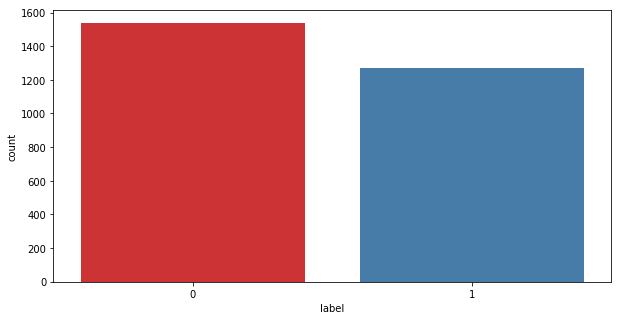

In [7]:
def plot_df(data_frame):
    plt.figure(figsize = (10, 5))
    chart = sns.countplot(data_frame['label'], 
                      palette="Set1"
                     )
    plt.show()

plot_df(df1)

The resulting dataframe has about 2,800 rows of text data with their labels marked as 0 (negative review) and 1 (positive review). There are about 200 more negative labels than the positive labels. 

# Loading the second csv file

In [8]:
def load_data(reviews_path):
    
    df2 = pd.read_csv(reviews_path)
    df2['label'] = np.where(df2['review_rating'] < 4, 0, 1)
    df2['text'] = df2['review_text']
    df2 = df2 [['text', 'label']]
    return df2

reviews_path = os.path.join(PROJ_ROOT, "data", "raw", "review.csv")
    
df2 = load_data(reviews_path) 

assert df2.shape == (460, 2)

In [9]:
df1.head()

,text,label
0,Fascinating view into the past: This book is f...,1
1,A very amusing look at the past: I was hoping ...,1
2,Didn't like...: I didn't like this version of ...,0
3,"Two Divas,that should shut up!: Here are two s...",0
4,Movie Version is Much better!: The movie versi...,0


In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 2 columns):
text     460 non-null object
label    460 non-null int64
dtypes: int64(1), object(1)
memory usage: 7.3+ KB


In [11]:
df2['label'].value_counts()

1    342
0    118
Name: label, dtype: int64

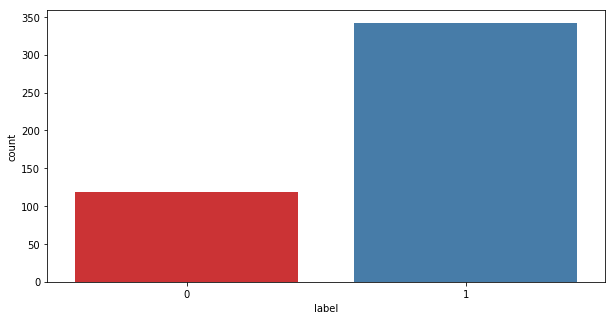

In [12]:
plot_df(df2)

The resulting dataframe has about 460 rows of text data with their labels marked from 1 to 5. I chose an arbitrary cut-off of 3 therefore labeling all reviews marked from 1 to 3 negative (i.e marked with a zero) and all other reviews marked from 4 upwards marked positive (i.e marked with a one). The resulting labels were about 300 reviews marked positive (i.e 1) and about 100 reviews marked negative (i.e 0).

# Joining the two dataframes

In [13]:
frames = [df1, df2]
df = pd.concat(frames)
df.shape

(3268, 2)

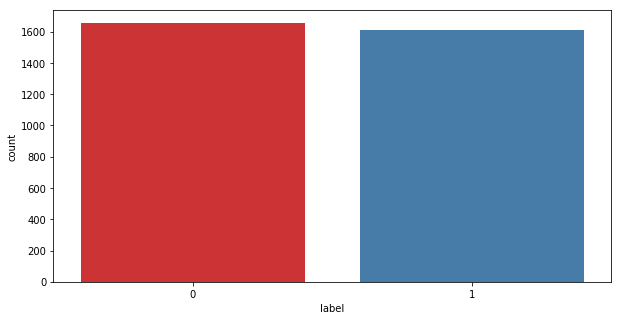

In [14]:
plot_df(df)

In [15]:
df.head()

,text,label
0,Fascinating view into the past: This book is f...,1
1,A very amusing look at the past: I was hoping ...,1
2,Didn't like...: I didn't like this version of ...,0
3,"Two Divas,that should shut up!: Here are two s...",0
4,Movie Version is Much better!: The movie versi...,0


In [16]:
df['label'].value_counts()

0    1656
1    1612
Name: label, dtype: int64

In [17]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, r'[\d+\s<^>+@#\>]', ' ', replace_global=True)
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '', replace_global=True)

df['text'] = custom_standardization(df['text'])

In [18]:
df.head()

,text,label
0,b'fascinating view into the past this book is ...,1
1,b'a very amusing look at the past i was hoping...,1
2,b'didnt like i didnt like this version of the ...,0
3,b'two divasthat should shut up here are two so...,0
4,b'movie version is much better the movie versi...,0


In [21]:
df.to_pickle("./reviews4.pkl")

# Tokenizing and plotting the text distribution

In [19]:
def words_per_sample(sample_texts):
    """Tokenizes sentences into words
    # Arguments
        sample_texts: list, sample texts.
    # Returns
        word tokens.
    """
    words = [s.split() for s in sample_texts]
    return words

text = words_per_sample(df['text'])

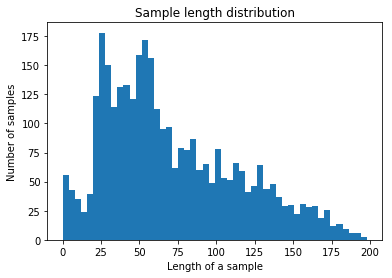

In [20]:
def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.

    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()

plot_sample_length_distribution(text)

Most sentences contain anywhere from 25 words to about50 words. The longest sentence contains close to 200 words and the shortest sentence containing no words.